<a href="https://colab.research.google.com/github/harshsugandh/Walmart-Store-Sales-Forecasting/blob/master/Project_MLapps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Getting CSV files and importing the required packages

In [ ]:
#getting csv files
!wget https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/features.csv
!wget https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/stores.csv
!wget https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/test.csv
!wget https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/train.csv

--2020-09-15 20:22:25--  https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592289 (578K) [text/plain]
Saving to: ‘features.csv.3’

features.csv.3      100%[===================>] 578.41K  --.-KB/s    in 0.03s   

2020-09-15 20:22:25 (17.5 MB/s) - ‘features.csv.3’ saved [592289/592289]

--2020-09-15 20:22:26--  https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/stores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [ ]:
#importing required packages and libraries
import numpy as np
import pandas as pd
import os
import datetime
import warnings
import matplotlib.pyplot as plt
from time import time
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
warnings.filterwarnings('ignore')

Defining functions to be used later in the modeling

In [ ]:
def distribution(data, features, transformed = False):

    #Visualization code for displaying distributions of features
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(features):
        axisg = fig.add_subplot(1, 2, i+1)
        axisg.hist(data[feature], bins = 25, color = '#00A0A0')
        axisg.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        axisg.set_xlabel("Value")
        axisg.set_ylabel("Number of Records")
        axisg.set_ylim((0, 2000))
        axisg.set_yticks([0, 500, 1000, 1500, 2000])
        axisg.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

In [ ]:
def eval_train_predict(learner, sample_size, train_X, train_y, test_X, test_y, transform_y, log_constant): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set       
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['WMAE'] = weighted_mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant, 
                                                       compute_weights(test_X['IsHoliday']))
    else:
        results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
                   
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
def eval_visualize(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize = (18,8))

    # Constants
    bar_width = 0.1
    colors = ['#A00000','#00A0A0','#00A000','#E3DAC9','#555555', '#87CEEB']
    metrics = ['time_train', 'time_pred', 'WMAE']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(metrics):
            # Creative plot code
            ax[j%3].bar(0+k*bar_width, results[learner][0][metric], width = bar_width, color = colors[k])
            ax[j%3].set_xlabel("Models")
            ax[j%3].set_xticklabels([''])
                
    # Add unique y-labels
    ax[0].set_ylabel("Time (in seconds)")
    ax[1].set_ylabel("Time (in seconds)")
    ax[2].set_ylabel("WMAE")
    
    # Add titles
    ax[0].set_title("Model Training")
    ax[1].set_title("Model Predicting")
    ax[2].set_title("WMAE on Testing Set")
 
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.43), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [ ]:
def train_predict(learner, train_X, train_y, test_X, test_y, transform_y, log_constant, verbose=0): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X, train_y)
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['WMAE'] = weighted_mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant, 
                                                       compute_weights(test_X['IsHoliday']))
    else:
        results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
    

    #Extract the feature importances
    importances = learner.feature_importances_

    # Success
    print("Learner Name :", learner.__class__.__name__)
    print("Training     :", round(results['time_train'],2), "secs /", len(train_y), "records")
    print("Predicting   :", round(results['time_pred'],2), "secs /", len(test_y), "records")
    print("Weighted MAE :", round(results['WMAE'],2))

    if verbose == 1:
        # Plot
        print("\n<Feature Importance>\n")
        feature_plot(importances, train_X, train_y, 10)

        print("\n<Feature Weightage>\n")
        topk = len(train_X.columns)
        indices = np.argsort(importances)[::-1]
        columns = train_X.columns.values[indices[:topk]]
        values = importances[indices][:topk]

        for i in range(topk):
            print('\t' + columns[i] + (' ' * (15 - len(columns[i])) + ': ' + str(values[i])))
            
        print("\n<Learner Params>\n", model.get_params())
    
    # Return the model & predictions
    return (learner, predictions)

In [ ]:
def feature_plot(importances, train_X, train_y, topk=5):
    
    # Display the most important features
    indices = np.argsort(importances)[::-1]
    columns = train_X.columns.values[indices[:topk]]
    values = importances[indices][:topk]

    # Creat the plot
    fig = plt.figure(figsize = (18,5))
    plt.title("Normalized Weights for First " + str(topk) + " Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(topk), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(topk) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(topk), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

In [ ]:
def reduce_mem_usage(df, verbose=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def weighted_mean_absolute_error(pred_y, test_y, weights):
    return 1/sum(weights) * sum(weights * abs(test_y - pred_y))

In [ ]:
def compute_weights(holidays):
    return holidays.apply(lambda x: 1 if x==0 else 5)

###Exploratory Data Analysis

In [ ]:
#reading the data files
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
#store dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [ ]:
#missing data
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


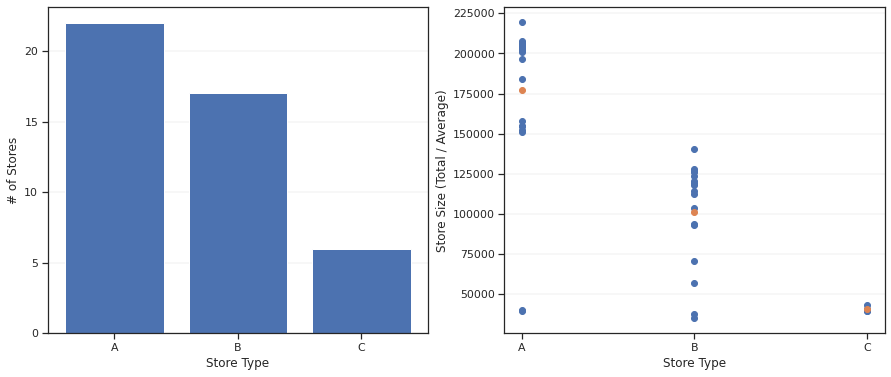

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).count())
ax[0].set_ylabel('# of Stores')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].scatter(stores['Type'], stores['Size'])
ax[1].scatter(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).mean()) #Store Type Average Store Size Vs 
ax[1].set_ylabel('Store Size (Total / Average)')
ax[1].set_xlabel('Store Type')
ax[1].yaxis.grid(True, linewidth=0.3)

In [ ]:
stores[(stores['Size'] < 40000) & (~stores['Type'].isin(['C']))]

,Store,Type,Size
2,3,B,37392
4,5,B,34875
32,33,A,39690
35,36,A,39910


In [ ]:
#feature dataset
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [ ]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


<BarContainer object of 12 artists>

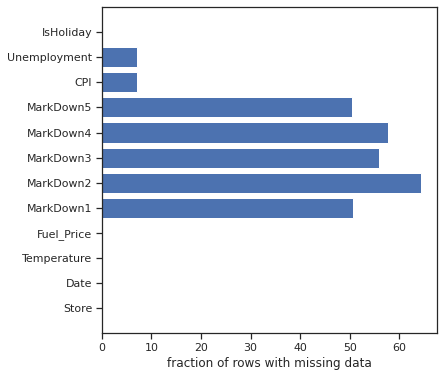

In [ ]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

In [ ]:
#train dataset
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
#test dataset
test.head()


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


###Data description and Initial Processing

In [ ]:
#1. Missing/Incorrect Values
#Stores Data | Correct Type for 4 store

stores[stores['Store'].isin([3,5,33,36])].index

Int64Index([2, 4, 32, 35], dtype='int64')

In [ ]:
stores.iat[2, 1] = stores.iat[4, 1] = stores.iat[32, 1] = stores.iat[35, 1] = 'C'

In [ ]:
#Features Data | Negative values for MarkDowns:
features['MarkDown1'] = features['MarkDown1'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown2'] = features['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown3'] = features['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown4'] = features['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown5'] = features['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
#Features Data | NaN values for multiple columns:

#Columns: CPI and Unemployment
#As noted above, columns are missing values for 3 months May, Jun & Jul 2013. Values from Apr would be propogated to records with missing values.

%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 3.14 s, sys: 3.17 ms, total: 3.15 s
Wall time: 3.16 s


In [ ]:
#Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5
#As noted above, columns MARKDOWN* are missing values for the whole of 2010 and 2011 (upto Nov). For each store, 2012 values would be copied over to records with missing values. Also, to facilitate the copy, new columns WEEK and YEAR would be derived from DATE.

%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 4.85 s, sys: 652 µs, total: 4.85 s
Wall time: 4.86 s


In [ ]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)


In [ ]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [ ]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]        


CPU times: user 1min 5s, sys: 460 ms, total: 1min 6s
Wall time: 1min 5s


In [ ]:
features.drop(columns=['Year'], axis=1, inplace=True)


In [ ]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

In [ ]:
#Train Data | Negative Values for Weekly Sales
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
#2. Merge Datasets
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [ ]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [ ]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [ ]:
#removing the duplicate column
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [ ]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)


###Feature Engineering

Column #1: IsHoliday
Column has boolean values and would ned converted to numeric.

In [ ]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

Column #2: Type
Column is categorical and would be converted to numeric via one-hot encoding.

In [ ]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

Column #3: Week
New numeric column being created to replace YEAR.

In [ ]:
train['Week'] = test['Week'] = 0

In [ ]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 4min 47s, sys: 61.2 ms, total: 4min 48s
Wall time: 4min 48s


In [ ]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 1min 17s, sys: 17.6 ms, total: 1min 17s
Wall time: 1min 17s


In [ ]:
train['Year'] = train['Date'].str.slice(start=0, stop=4)
test['Year'] = test['Date'].str.slice(start=0, stop=4)

In [ ]:
# Drop non-numeric columns
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

Log Transform Skewed Features

In [ ]:
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train[skewed] = train[skewed].apply(lambda x: np.log(x + 1))
test[skewed] = test[skewed].apply(lambda x: np.log(x + 1))

In [ ]:
log_constant = 0

In [ ]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: np.log(x + 1 + log_constant))

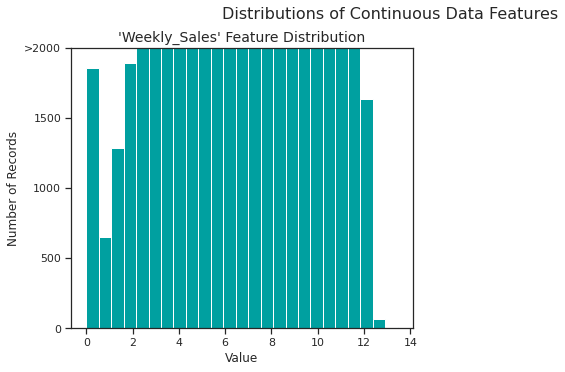

In [ ]:
distribution(train, ['Weekly_Sales'])

Analyze Feature Correlation

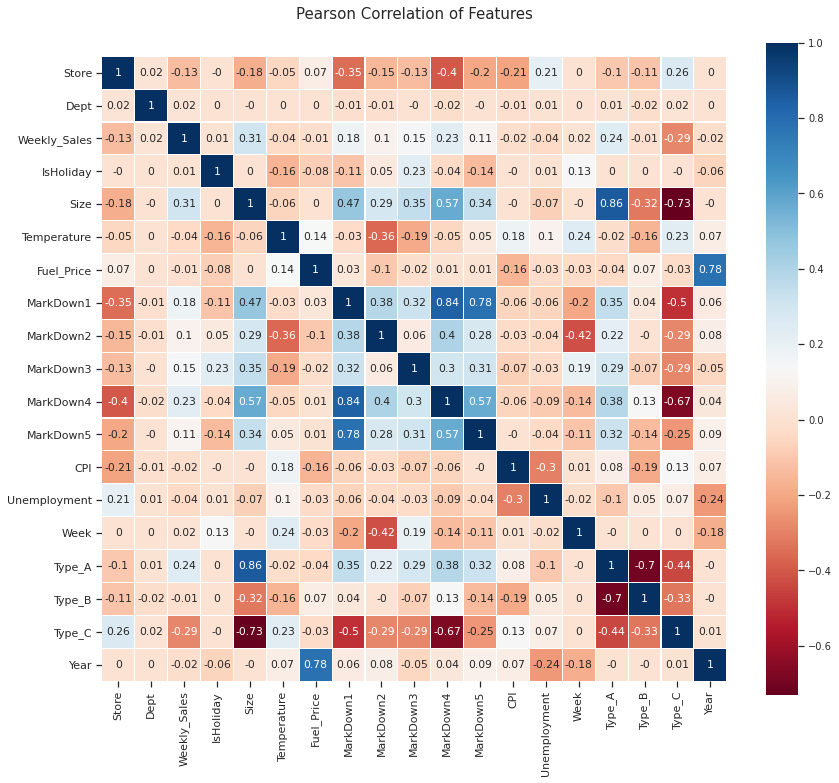

In [ ]:
colormap = plt.cm.RdBu
corr = train.astype(float).corr()

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [ ]:
corr_cutoff = 0.8
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_cutoff:
            if columns[j]:
                columns[j] = False
                
selected_columns = train.columns[columns]
highcorr_columns = train.columns.difference(selected_columns)

In [ ]:
highcorr_columns

Index(['MarkDown4', 'Type_A'], dtype='object')

In [ ]:
train.drop(columns=highcorr_columns, axis=1, inplace=True)
test.drop(columns=highcorr_columns, axis=1, inplace=True)

Takeaway:
MarkDown4 and Type_A are highly correlated to other existing features and have been dropped.

Split Training dataset into Train & Validation

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(train.drop('Weekly_Sales', axis = 1), 
                                                  train['Weekly_Sales'], 
                                                  test_size = 0.2, 
                                                  random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [ ]:
# Validate shape
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test.shape

((337256, 16), (337256,), (84314, 16), (84314,), (115064, 16))

In [ ]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 
             'CPI', 'Unemployment', 'Week', 'Type_B', 'Type_C','Year',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown5']

train_scaled = pd.DataFrame(data = train_X)
train_scaled[numerical] = scaler.fit_transform(train_X[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
201850,0.454545,0.316327,0.0,0.569925,0.438160,0.272545,0.737133,0.605471,0.125485,0.610801,0.844356,0.397642,0.039216,1.0,0.0,0.5
263688,0.590909,0.581633,0.0,0.916437,0.788454,0.194389,0.890191,0.355430,0.472189,0.633988,0.104035,0.393234,0.666667,0.0,0.0,0.0
147390,0.318182,0.948980,0.0,0.480993,0.604207,0.184369,0.751482,0.262312,0.042536,0.635216,0.066155,0.401380,0.745098,1.0,0.0,0.0
169866,0.386364,0.183673,0.0,0.464300,0.714090,0.579659,0.791126,0.534033,0.072421,0.617590,0.119591,0.424094,0.470588,1.0,0.0,1.0
253398,0.568182,0.551020,0.0,0.636752,0.481703,0.759519,0.664863,0.304229,0.261758,0.566154,0.082750,0.377516,0.313725,0.0,0.0,0.5


In [ ]:
val_scaled = pd.DataFrame(data = val_X)
val_scaled[numerical] = scaler.transform(val_X[numerical])

# Show an example of a record with scaling applied
display(val_scaled.head(n = 5))


,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
233571,0.522727,0.551020,0.0,0.914461,0.565656,0.861723,0.865404,0.455363,0.443000,0.627616,0.083527,0.415277,0.333333,0.0,0.0,0.5
88992,0.204545,0.102041,0.0,0.496013,0.692955,0.329659,0.805416,0.360259,0.387339,0.496319,0.003681,0.491087,0.823529,1.0,0.0,0.0
367842,0.863636,0.591837,0.0,0.807775,0.834638,0.090681,0.781498,0.476005,0.057754,0.802748,0.830627,0.439429,0.470588,0.0,0.0,0.0
184359,0.409091,0.602041,0.0,0.914461,0.620157,0.714930,0.817083,0.432713,0.224436,0.672905,0.101840,0.376366,0.725490,0.0,0.0,0.5
26175,0.045455,0.448980,0.0,0.013624,0.480724,0.021042,0.693787,0.696427,0.088778,0.545715,0.875328,0.334388,0.117647,0.0,1.0,0.0


In [ ]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
0,0.0,0.0,0.0,0.630267,0.561448,0.457916,0.774188,0.739500,0.331330,0.583883,0.962735,0.258194,0.843137,0.0,0.0,1.0
1,0.0,0.0,0.0,0.630267,0.619374,0.421844,0.820135,0.702875,0.312245,0.643629,0.962918,0.258194,0.862745,0.0,0.0,1.0
2,0.0,0.0,0.0,0.630267,0.537965,0.390782,0.805763,0.491516,0.390422,0.648929,0.963231,0.258194,0.882353,0.0,0.0,1.0
3,0.0,0.0,1.0,0.630267,0.570352,0.370240,0.595582,0.142152,0.942015,0.421811,0.963716,0.258194,0.901961,0.0,0.0,1.0
4,0.0,0.0,0.0,0.630267,0.532290,0.368236,0.685397,0.000000,0.692664,0.652772,0.964200,0.258194,0.921569,0.0,0.0,1.0


In [ ]:
# Free up memory
#train = test = features = stores = None

In [ ]:
train_X = train_scaled
val_X = val_scaled

In [ ]:
# Free up memory
#train_scaled = val_scaled = None
train_X.head()


,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Unemployment,Week,Type_B,Type_C,Year
201850,0.454545,0.316327,0.0,0.569925,0.438160,0.272545,0.737133,0.605471,0.125485,0.610801,0.844356,0.397642,0.039216,1.0,0.0,0.5
263688,0.590909,0.581633,0.0,0.916437,0.788454,0.194389,0.890191,0.355430,0.472189,0.633988,0.104035,0.393234,0.666667,0.0,0.0,0.0
147390,0.318182,0.948980,0.0,0.480993,0.604207,0.184369,0.751482,0.262312,0.042536,0.635216,0.066155,0.401380,0.745098,1.0,0.0,0.0
169866,0.386364,0.183673,0.0,0.464300,0.714090,0.579659,0.791126,0.534033,0.072421,0.617590,0.119591,0.424094,0.470588,1.0,0.0,1.0
253398,0.568182,0.551020,0.0,0.636752,0.481703,0.759519,0.664863,0.304229,0.261758,0.566154,0.082750,0.377516,0.313725,0.0,0.0,0.5


###Modelling
Select and evaluate candidate models

In [ ]:
clf = RandomForestRegressor(random_state=1)
clf.fit(train_X, train_y)
y_pred = clf.predict(val_X)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(val_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(val_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_y, y_pred)))

Mean Absolute Error: 0.180536530664242
Mean Squared Error: 0.14041269479962012
Root Mean Squared Error: 0.3747168194778827


In [ ]:
import sklearn
import math
mse = sklearn.metrics.mean_squared_error(val_y, y_pred)
rmse = math.sqrt(mse)
print('Accuracy for Random Forest',100*max(0,rmse)) 

Accuracy for Random Forest 37.47168194778827


In [ ]:
errors = abs(y_pred - val_y)
errors.head

<bound method NDFrame.head of 233571    0.135139
88992     0.032989
367842    0.130153
184359    0.143612
26175     0.685874
            ...   
392371    0.151566
389905    0.013255
406834    0.066215
118116    0.032749
329386    0.054802
Name: Weekly_Sales, Length: 84314, dtype: float64>

In [ ]:
mape = 100 * (errors / val_y)
accuracy = 100 - np.mean(mape)
accuracy

-inf

In [ ]:
%%time
# Initialize base models
model_A = LinearRegression()
model_B = ElasticNet(random_state=1)
model_C = RandomForestRegressor(random_state=1)
model_D = GradientBoostingRegressor(random_state=1)
model_E = xgb.XGBRegressor()
model_F = LGBMRegressor(random_state=1)

samples = len(train_y) # 100% of training set

# Collect results on the learners
results = {}
for model in [model_A, model_B, model_C, model_D, model_E, model_F]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples]):
        results[model_name][i] = eval_train_predict(model, samples, train_X, train_y, val_X, val_y, 'log', log_constant)

LinearRegression trained on 337256 samples.
ElasticNet trained on 337256 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 337256 samples.
[20:54:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 337256 samples.
CPU times: user 8min 52s, sys: 1.44 s, total: 8min 53s
Wall time: 8min 54s


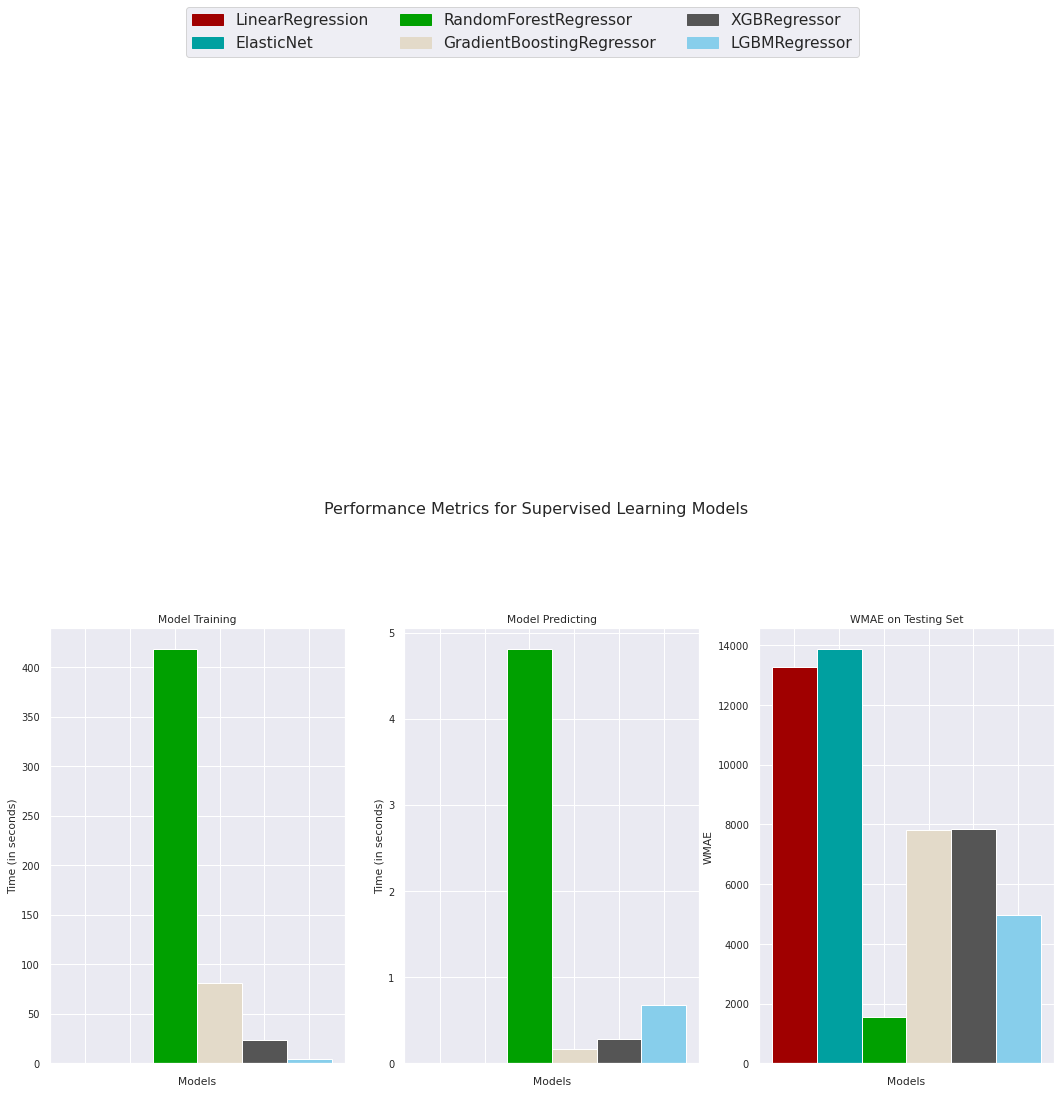

In [ ]:
# Evaluate Metrics
eval_visualize(results)

In [ ]:
results

{'ElasticNet': {0: {'WMAE': 13874.268546310475,
   'time_pred': 0.002388477325439453,
   'time_train': 0.05275440216064453}},
 'GradientBoostingRegressor': {0: {'WMAE': 7813.675837167315,
   'time_pred': 0.1700422763824463,
   'time_train': 81.30352306365967}},
 'LGBMRegressor': {0: {'WMAE': 4961.648932996019,
   'time_pred': 0.6719517707824707,
   'time_train': 4.376567363739014}},
 'LinearRegression': {0: {'WMAE': 13288.278997851772,
   'time_pred': 0.003039121627807617,
   'time_train': 0.21391820907592773}},
 'RandomForestRegressor': {0: {'WMAE': 1543.594708980336,
   'time_pred': 4.807226896286011,
   'time_train': 418.22919249534607}},
 'XGBRegressor': {0: {'WMAE': 7843.392922174124,
   'time_pred': 0.2829618453979492,
   'time_train': 23.839146375656128}}}

In [ ]:
rf = RandomForestRegressor(random_state = 1)
rf.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [ ]:
predictions = rf.predict(test_scaled)
predictions.shape

(115064,)

In [ ]:
predictions = rf.predict(val_X)
predictions.shape

(84314,)

In [ ]:
import sklearn
import math
mse = sklearn.metrics.mean_squared_error(val_y, predictions)
rmse = math.sqrt(mse)
print('Accuracy for Random Forest',100*max(0,rmse)) 

Accuracy for Random Forest 37.47168194778827


In [ ]:
!wget https://raw.githubusercontent.com/harshsugandh/Walmart-Store-Sales-Forecasting/master/sampleSubmission.csv


In [ ]:
predictions = np.exp(predictions) - 1 - log_constant
predictions

In [ ]:
submission = pd.read_csv("sampleSubmission.csv")

In [ ]:
submission['Weekly_Sales'] = predictions
submission.head()


In [ ]:
submission[['Id','Weekly_Sales']].to_csv('submission.csv', index=False)